<a href="https://colab.research.google.com/github/ahhdong/Text-Classification/blob/master/meme_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-class Classification

## Load file and read csv file

In [ ]:
import pandas as pd
import numpy as np
import re
import time

!pip install langdetect 
from langdetect import detect

SEED=100

     |████████████████████████████████| 983kB 3.5MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=c1da3d27bd089e2a156d0a3d0aff765f975323b29200072b5a0ad93b25ee08be
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving labels.csv to labels.csv


In [ ]:
import io
df_meme = pd.read_csv(io.BytesIO(uploaded['labels.csv']))
df_meme.head()

,Unnamed: 0,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


## Reframe the data and encode categorical value

In [ ]:
data = df_meme[['text_corrected','overall_sentiment']].copy()
data['text_corrected'] = data['text_corrected'].astype('str')
data.dropna(subset=['text_corrected','overall_sentiment'],inplace=True)
data.reset_index(drop=True, inplace=True)
data.shape

(6992, 2)

Encode categorical value

In [ ]:
data.loc[:,('overall_sentiment')] = data.overall_sentiment.map({"very_positive" : 1, "positive" : 1, "neutral" : 0, "negative" : -1, "very_negative" : -1 })

## Exploratary Data Analysis

Detect Language

In [ ]:
data['langue'] = data['text_corrected'].apply(detect)

In [ ]:
data['langue'].value_counts()

en    5833
de     404
pt     247
so     101
no      74
vi      58
da      43
id      33
fr      32
cy      25
nl      23
it      18
ca      15
tl      14
ro      13
af      10
sw      10
pl       8
hu       7
et       6
hr       4
sv       4
es       3
uk       2
ta       1
sq       1
tr       1
sl       1
cs       1
Name: langue, dtype: int64

In [ ]:
# keep the text written in English
data = data[data.langue == 'en']
data.reset_index(drop=True, inplace=True)
data.shape

(5833, 3)

Wordcloud of the raw text data

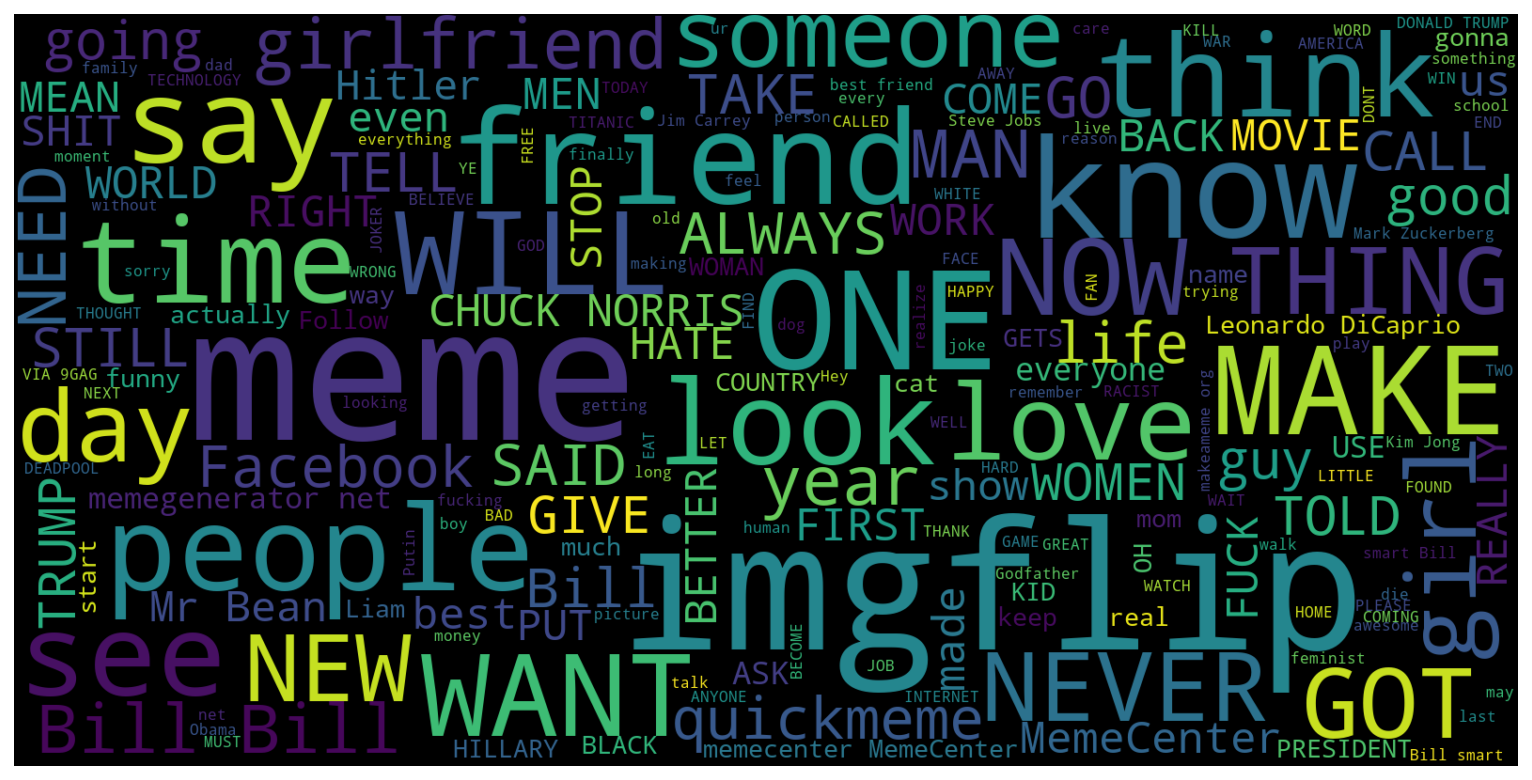

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud
unclean_text = data['text_corrected']
unclean_string = []
for t in unclean_text.values:
    unclean_string.append(t)
unclean_string = pd.Series(unclean_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(unclean_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Data preprocessing and normalisation

In [ ]:
import nltk
# credit from https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
#credit from:https://datasciencetoday.net/index.php/en-us/tutorials-top/163-sentiment-analysis-using-python-part-i-machine-learning-model-comparison
negations_ = {"isn't":"is not", "can't":"can not","couldn't":"could not", "hasn't":"has not",
                "hadn't":"had not","won't":"will not",
                "wouldn't":"would not","aren't":"are not",
                "haven't":"have not", "doesn't":"does not","didn't":"did not",
                 "don't":"do not","shouldn't":"should not","wasn't":"was not", "weren't":"were not",
                "mightn't":"might not",
                "mustn't":"must not"}
negation_pattern = re.compile(r'\b(' + '|'.join(negations_.keys()) + r')\b')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    neg_handled = negation_pattern.sub(lambda x: negations_[x.group()], text)
    text = re.sub('quickmemecom|imgflipcom|memegeneratornet|memecentercom|meme', ' ', text)#some website's titles
    return text

data['text_corrected'] = data['text_corrected'].apply(clean_text)
## set X,y
# X = data['text_corrected']
# y = data["overall_sentiment"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Wordcloud of clean text data

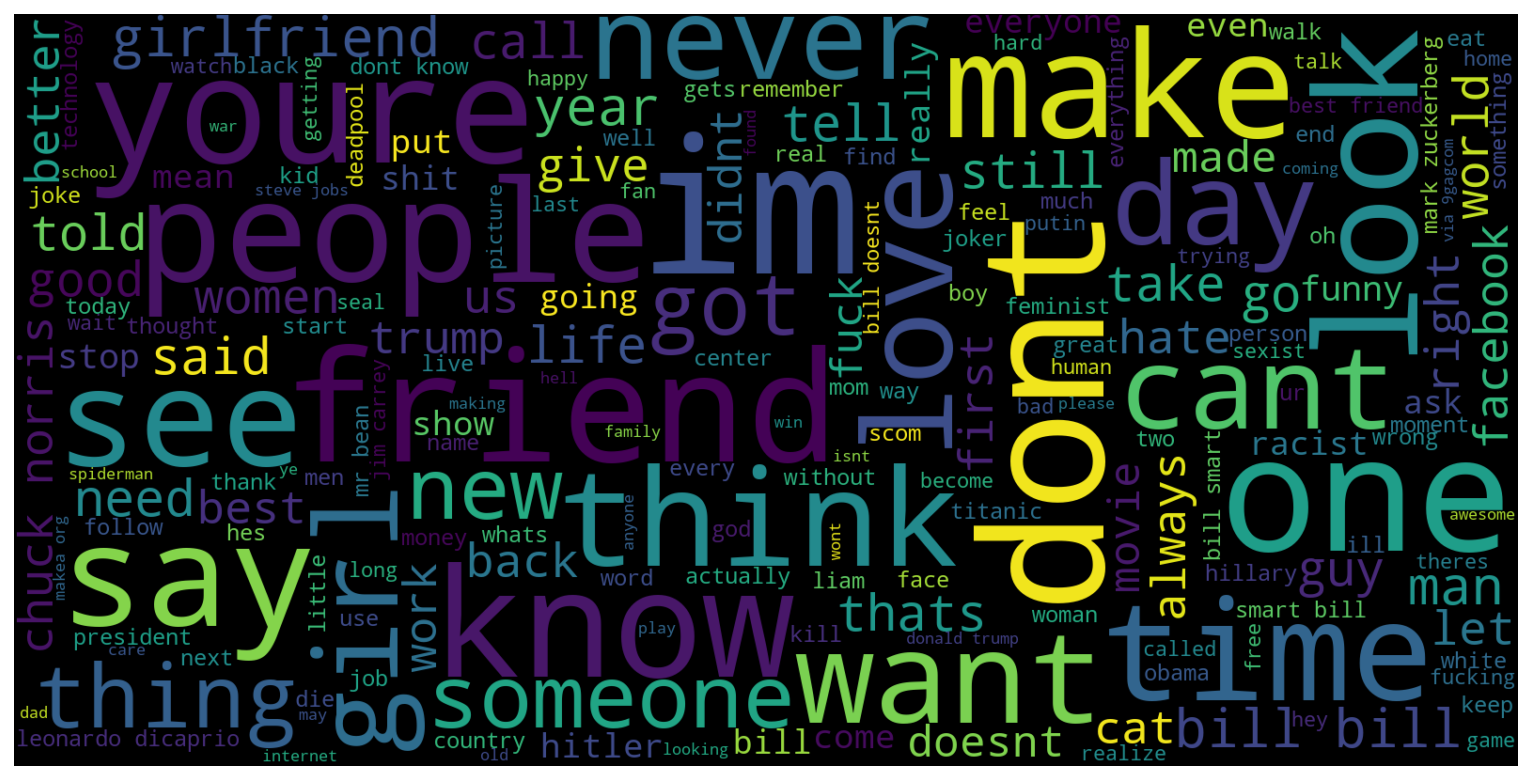

In [ ]:
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
clean_text = data['text_corrected']
clean_string = []
for t in clean_text.values:
    clean_string.append(t)
clean_string = pd.Series(clean_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(clean_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Wordcloud of positve and negative words

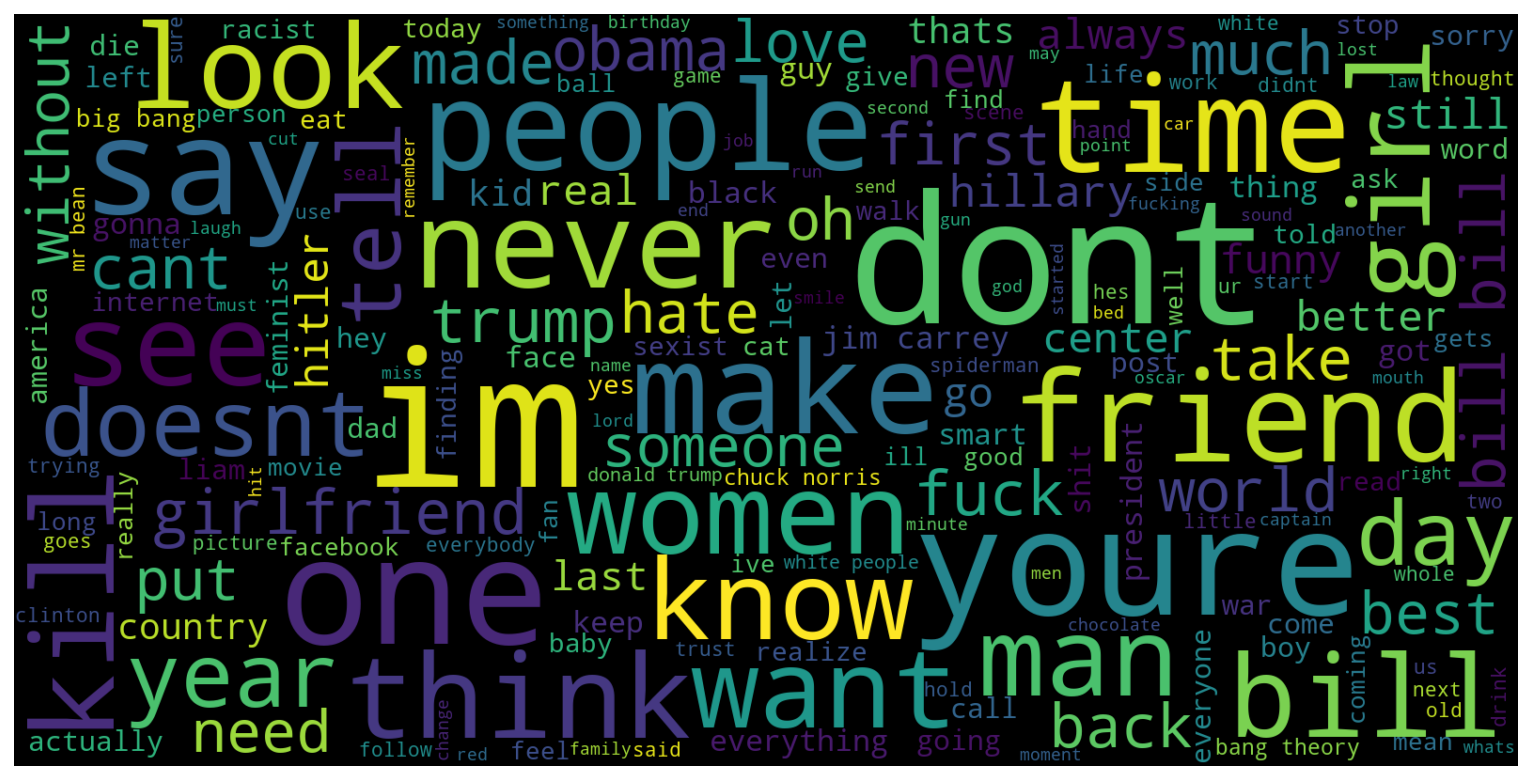

In [ ]:
#negative words wordcloud
neg_text = data[data.overall_sentiment == -1]
neg_string = []
for t in neg_text.text_corrected:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800, random_state=SEED, max_font_size=200).generate(neg_string)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

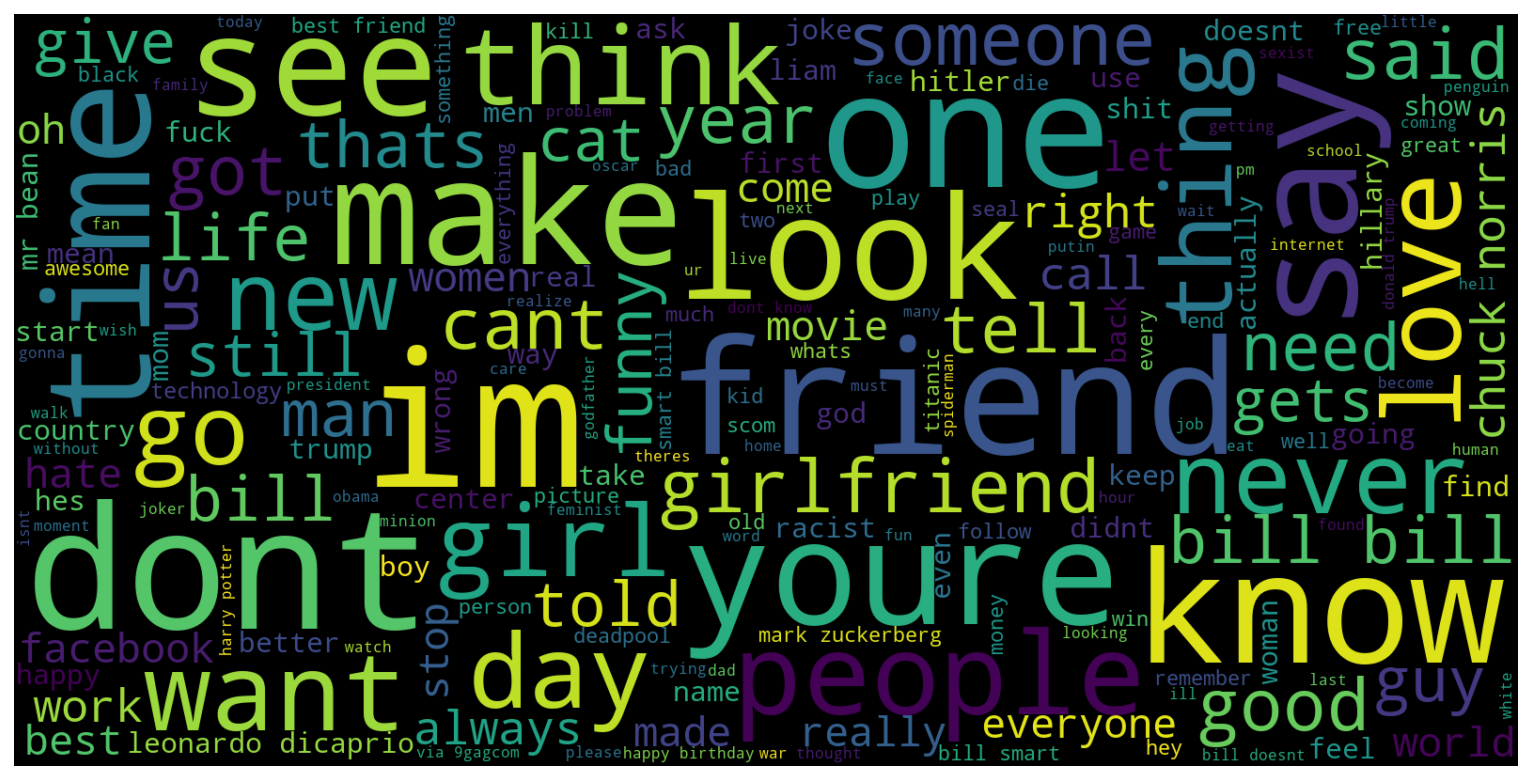

In [ ]:
# positive words wordcloud
pos_text = data[data.overall_sentiment == 1]
pos_string = []
for t in pos_text.text_corrected:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800, random_state=SEED, max_font_size=200).generate(pos_string)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Distribution of three classes:positive, neutral, negative

In [ ]:
# data.loc[:,('overall_sentiment')] = data.overall_sentiment.map({"very_positive" : 1, "positive" : 1, "neutral" : 0, "negative" : -1, "very_negative" : -1 })
data['overall_sentiment'].value_counts()

 1    3472
 0    1824
-1     537
Name: overall_sentiment, dtype: int64

the imbalanced ratio ≈ 6:4 (one vs rest)

# Resampling strategy for imbalanced data

In [ ]:
majority = len(data[data['overall_sentiment']==1])
minority = len(data[data['overall_sentiment']==0])  + len(data[data['overall_sentiment']==-1])
majority, minority

(3472, 2361)

In [ ]:
#over-sampling the minority classes
#credit from :https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=SEED)

# t_1 = data[data['overall_sentiment']==1].sample(2600,replace=True)
t_1 = data[data['overall_sentiment']==1]
t_2 = data[data['overall_sentiment']==0].sample(majority,replace=True)
t_3 = data[data['overall_sentiment']==-1].sample(majority,replace=True)
ros_df = pd.concat([t_1, t_2, t_3])

print(train.shape)
print(test.shape)
print(ros_df.shape)

# sanity check 
data.shape[0] == (train.shape[0] + test.shape[0])

(4660, 3)
(1165, 3)
(10401, 3)


True

In [ ]:
# undersampling the majority class
u_1 = data[data['overall_sentiment']==1].sample(minority,replace=True)
u_2 = data[data['overall_sentiment']==0]
u_3= data[data['overall_sentiment']==-1]
rus_df = pd.concat([u_1, u_2, u_3])

print(train.shape)
print(test.shape)
print(rus_df.shape)

# sanity check 
data.shape[0] == (train.shape[0] + test.shape[0])

(4660, 3)
(1165, 3)
(4716, 3)


True

# Choose which dataset to split training and testing data

In [ ]:
from sklearn.model_selection import train_test_split
# original dataset using stratify to give same distrubution of different labels
X = data['text_corrected']
y = data['overall_sentiment']
X_train,X_test,y_train,y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = SEED)

# Random oversapling dataset
# X_train,X_test,y_train,y_test = train_test_split(ros_df['text_corrected'], ros_df['overall_sentiment'],test_size = 0.2, random_state = SEED)

# Random undersapling dataset
# X_train,X_test,y_train,y_test = train_test_split(rus_df['text_corrected'], rus_df['overall_sentiment'],test_size = 0.2, random_state = SEED)

print("train tuples",X_train.shape)
print("train labels",y_train.shape)
print("test labels",y_test.shape)
print("test tuples",X_test.shape)

train tuples (4666,)
train labels (4666,)
test labels (1167,)
test tuples (1167,)


Feature representation

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer # text feature extraction and representation
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report #Evaluation matrics
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Set up ML model pipline

In [ ]:
#Navie Bayes models
BOW_NB = Pipeline([('bag_of_word',CountVectorizer()),('NB',MultinomialNB())])
tf_idf_NB = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])
#Logistic Regression models
BOW_LR = Pipeline([('bag_of_word',CountVectorizer()),('LR',LogisticRegression(random_state=SEED))])
tf_idf_LR = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(max_iter=1000, random_state=SEED)),
])
#Support vector machine models
BOW_SVM = Pipeline([('bag_of_word',CountVectorizer()),('SVM',svm.LinearSVC())])
tf_idf_SVM = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', svm.LinearSVC()),
])
#K nearest neighbors models
BOW_KNN = Pipeline([('bag_of_word',CountVectorizer()),('KNN',KNeighborsClassifier(n_neighbors=5))])
tf_idf_KNN = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors=5)),
])

In [ ]:
BOW_NB.fit(X_train,y_train)
tf_idf_NB.fit(X_train,y_train)

BOW_LR.fit(X_train,y_train)
tf_idf_LR.fit(X_train,y_train)

BOW_SVM.fit(X_train,y_train)
tf_idf_SVM.fit(X_train,y_train)

BOW_KNN.fit(X_train,y_train)
tf_idf_KNN.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
     

In [ ]:
NB1 = BOW_NB.predict(X_test)
NB2 = tf_idf_NB.predict(X_test)

LR1 = BOW_LR.predict(X_test)
LR2 = tf_idf_LR.predict(X_test)

SVM1 = BOW_SVM.predict(X_test)
SVM2 = tf_idf_SVM.predict(X_test)

KNN1 = BOW_KNN.predict(X_test)
KNN2 = tf_idf_KNN.predict(X_test)

In [ ]:
SVM1[40:60]

array([-1,  1,  0,  1,  1, -1,  0,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  0, -1])

In [ ]:
y_test[40:60]

2969     0
4648     0
3528     0
453      1
1364     1
3946     1
5210     1
407     -1
541      1
1414     0
1132     1
2856    -1
3317     1
514      1
4686     0
5064     1
3202     1
2252     1
5622    -1
3507     1
Name: overall_sentiment, dtype: object

In [ ]:
print('Train Accuracy: ',accuracy_score(y_train, BOW_NB.predict(X_train)))
print('Test Accuracy: ',accuracy_score(y_test, NB1))
print('Confusion Matrix:')
print(confusion_matrix(y_test, NB1))
target_names = ['negative', 'neutral', 'positive']
print('classification report for NB1')
print(classification_report(y_test, NB1,target_names=target_names))

Train Accuracy:  0.8793103448275862
Test Accuracy:  0.7045019157088123
Confusion Matrix:
[[628  26  33]
 [ 70 510 126]
 [137 225 333]]
classification report for NB1
              precision    recall  f1-score   support

    negative       0.75      0.91      0.83       687
     neutral       0.67      0.72      0.70       706
    positive       0.68      0.48      0.56       695

    accuracy                           0.70      2088
   macro avg       0.70      0.71      0.69      2088
weighted avg       0.70      0.70      0.69      2088



In [ ]:
print('Train Accuracy: ',accuracy_score(y_train, tf_idf_NB.predict(X_train)))
print('Test Accuracy: ',accuracy_score(y_test, NB2))
print('Confusion Matrix:')
print(confusion_matrix(y_test, NB2))
print('classification report for NB2')
print(classification_report(y_test, NB2,target_names=target_names))

Train Accuracy:  0.855667372881356
Test Accuracy:  0.5074152542372882
Confusion Matrix:
[[  0  13  81]
 [  0  42 344]
 [  0  27 437]]
classification report for NB2
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        94
     neutral       0.51      0.11      0.18       386
    positive       0.51      0.94      0.66       464

    accuracy                           0.51       944
   macro avg       0.34      0.35      0.28       944
weighted avg       0.46      0.51      0.40       944



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('Train Accuracy: ',accuracy_score(y_train, BOW_LR.predict(X_train)))
print('Test Accuracy: ',accuracy_score(y_test, LR1))
print('Confusion Matrix:')
print(confusion_matrix(y_test, LR1))
print('classification report for LR1')
print(classification_report(y_test, LR1,target_names=target_names))

Train Accuracy:  0.9658368644067796
Test Accuracy:  0.5561440677966102
Confusion Matrix:
[[  7  48  39]
 [ 12 162 212]
 [  8 100 356]]
classification report for LR1
              precision    recall  f1-score   support

    negative       0.26      0.07      0.12        94
     neutral       0.52      0.42      0.47       386
    positive       0.59      0.77      0.66       464

    accuracy                           0.56       944
   macro avg       0.46      0.42      0.42       944
weighted avg       0.53      0.56      0.53       944



In [ ]:
print('Train Accuracy: ',accuracy_score(y_train, tf_idf_LR.predict(X_train)))
print('Test Accuracy: ',accuracy_score(y_test, LR2))
print('Confusion Matrix:')
print(confusion_matrix(y_test, LR2))
print('classification report for LR2')
print(classification_report(y_test, LR2,target_names=target_names))

Train Accuracy:  0.8773834745762712
Test Accuracy:  0.5667372881355932
Confusion Matrix:
[[  0  39  55]
 [  0 143 243]
 [  0  72 392]]
classification report for LR2
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        94
     neutral       0.56      0.37      0.45       386
    positive       0.57      0.84      0.68       464

    accuracy                           0.57       944
   macro avg       0.38      0.41      0.38       944
weighted avg       0.51      0.57      0.52       944



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('Train Accuracy: ',accuracy_score(y_train, BOW_SVM.predict(X_train)))
print('Test Accuracy: ',accuracy_score(y_test, SVM1))
print('Confusion Matrix:')
print(confusion_matrix(y_test, SVM1))
print('classification report for SVM1')
print(classification_report(y_test, SVM1,target_names=target_names))

Train Accuracy:  0.9882403249946546
Test Accuracy:  0.5034188034188034
Confusion Matrix:
[[  9  30  69]
 [ 24 116 227]
 [ 37 194 464]]
classification report for SVM1
              precision    recall  f1-score   support

    negative       0.13      0.08      0.10       108
     neutral       0.34      0.32      0.33       367
    positive       0.61      0.67      0.64       695

    accuracy                           0.50      1170
   macro avg       0.36      0.36      0.36      1170
weighted avg       0.48      0.50      0.49      1170



In [ ]:
print('Train Accuracy: ',accuracy_score(y_train, tf_idf_SVM.predict(X_train)))
print('Test Accuracy: ',accuracy_score(y_test, SVM2))
print('Confusion Matrix:')
print(confusion_matrix(y_test, SVM2))
print('classification report for SVM2')
print(classification_report(y_test, SVM2,target_names=target_names))

Train Accuracy:  0.9970868644067796
Test Accuracy:  0.5646186440677966
Confusion Matrix:
[[  4  49  41]
 [ 14 171 201]
 [ 10  96 358]]
classification report for SVM2
              precision    recall  f1-score   support

    negative       0.14      0.04      0.07        94
     neutral       0.54      0.44      0.49       386
    positive       0.60      0.77      0.67       464

    accuracy                           0.56       944
   macro avg       0.43      0.42      0.41       944
weighted avg       0.53      0.56      0.54       944



In [ ]:
print('Train Accuracy: ',accuracy_score(y_train, BOW_KNN.predict(X_train)))
print('Test Accuracy: ',accuracy_score(y_test, KNN1))
print('Confusion Matrix:')
print(confusion_matrix(y_test, KNN1))
print('classification report for KNN1')
print(classification_report(y_test, KNN1,target_names=target_names))

Train Accuracy:  0.6432733050847458
Test Accuracy:  0.4915254237288136
Confusion Matrix:
[[  4  23  67]
 [ 12  95 279]
 [  7  92 365]]
classification report for KNN1
              precision    recall  f1-score   support

    negative       0.17      0.04      0.07        94
     neutral       0.45      0.25      0.32       386
    positive       0.51      0.79      0.62       464

    accuracy                           0.49       944
   macro avg       0.38      0.36      0.34       944
weighted avg       0.45      0.49      0.44       944



In [ ]:
print('Train Accuracy: ',accuracy_score(y_train, tf_idf_KNN.predict(X_train)))
print('Test Accuracy: ',accuracy_score(y_test, KNN2))
print('Confusion Matrix:')
print(confusion_matrix(y_test, KNN2))
print('classification report for KNN2')
print(classification_report(y_test, KNN2,target_names=target_names))

Train Accuracy:  0.6483050847457628
Test Accuracy:  0.5063559322033898
Confusion Matrix:
[[  5  42  47]
 [ 36 190 160]
 [ 36 145 283]]
classification report for KNN2
              precision    recall  f1-score   support

    negative       0.06      0.05      0.06        94
     neutral       0.50      0.49      0.50       386
    positive       0.58      0.61      0.59       464

    accuracy                           0.51       944
   macro avg       0.38      0.39      0.38       944
weighted avg       0.50      0.51      0.50       944



In [ ]:
# from sklearn.linear_model import SGDClassifier

# sgd = Pipeline([('vect', CountVectorizer()),
#                 ('tfidf', TfidfTransformer()),
#                 ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=SEED, max_iter=1000, tol=None)),
#                ])
# sgd.fit(X_train, y_train)



# pre5 = sgd.predict(X_test)
# print('Train Accuracy: ',accuracy_score(y_train, sgd.predict(X_train)))
# print('accuracy %s' % accuracy_score(pre5, y_test))
# print(classification_report(y_test, pre5,target_names=target_names))

# RNN using word embedding & word2vec

In [ ]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D, BatchNormalization
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing 
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer

import gensim.models.keyedvectors as word2vec #need to use due to depreceated model

## Basic wordembedding

In [ ]:
# different dataset: unchanged dataset, random oversampling, random undersampling
X = data['text_corrected']
y = data['overall_sentiment']

# X = ros_df['text_corrected']
# y = ros_df['overall_sentiment']

# X = rus_df['text_corrected']
# y = rus_df['overall_sentiment']

In [ ]:
#model-LSTM credit from:https://www.kaggle.com/wahabakram45/twittersentimentsclassification#Data-Preprocessing
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()
Y = label_encoder.fit_transform(y)
Y = to_categorical(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = SEED)
max_words = len(set(" ".join(X_train).split()))
# max_len = X_train.apply(lambda x: len(x)).max()
max_len = 100

In [ ]:
max_words, max_len

(9306, 100)

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq = sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq = sequence.pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
def Rnn_model():
    model = Sequential()
    
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(LSTM(256))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
  
    
    model.summary()
    
    return model

In [ ]:
RNNmodel = Rnn_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1165000   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

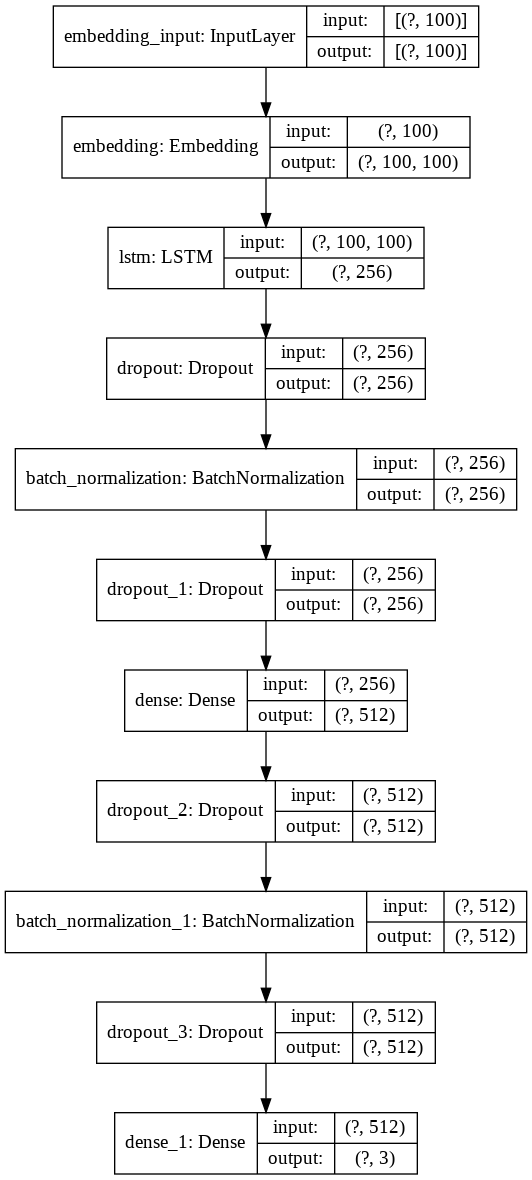

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(RNNmodel, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
RNNmodel.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
%%time
batch_size = 64
history = RNNmodel.fit(X_train_seq, 
                    Y_train, 
                    epochs = 5, 
                    batch_size=batch_size, 
                    validation_split=0.1
                    )

Epoch 1/5
60/60 [==============================] - 4s 64ms/step - loss: 1.7393 - accuracy: 0.3787 - val_loss: 0.9589 - val_accuracy: 0.4977
Epoch 2/5
60/60 [==============================] - 3s 53ms/step - loss: 1.4374 - accuracy: 0.4066 - val_loss: 0.9784 - val_accuracy: 0.4977
Epoch 3/5
60/60 [==============================] - 3s 52ms/step - loss: 1.2744 - accuracy: 0.4163 - val_loss: 0.9582 - val_accuracy: 0.4977
Epoch 4/5
60/60 [==============================] - 3s 49ms/step - loss: 1.1583 - accuracy: 0.4249 - val_loss: 0.9602 - val_accuracy: 0.4977
Epoch 5/5
60/60 [==============================] - 3s 49ms/step - loss: 1.0830 - accuracy: 0.4252 - val_loss: 0.9582 - val_accuracy: 0.4977
CPU times: user 11.6 s, sys: 1.07 s, total: 12.7 s
Wall time: 18.7 s


In [ ]:
y_pre = RNNmodel.predict(X_test_seq)

In [ ]:
y_pre

array([[0.10143668, 0.40958035, 0.488983  ],
       [0.10098956, 0.40886274, 0.49014768],
       [0.10127238, 0.4092595 , 0.48946816],
       ...,
       [0.10087935, 0.40949547, 0.48962516],
       [0.10122818, 0.40898475, 0.4897871 ],
       [0.10158913, 0.409156  , 0.4892549 ]], dtype=float32)

In [ ]:
from sklearn.metrics import classification_report
Y_pre = np.zeros_like(y_pre)
Y_pre[np.arange(len(y_pre)), y_pre.argmax(1)] = 1

In [ ]:
from sklearn.metrics import confusion_matrix
# print(confusion_matrix(Y_test, Y_pre))
print(classification_report(Y_test, Y_pre))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.00      0.00      0.00       184
           2       0.51      1.00      0.67       240

   micro avg       0.51      0.51      0.51       473
   macro avg       0.17      0.33      0.22       473
weighted avg       0.26      0.51      0.34       473
 samples avg       0.51      0.51      0.51       473



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


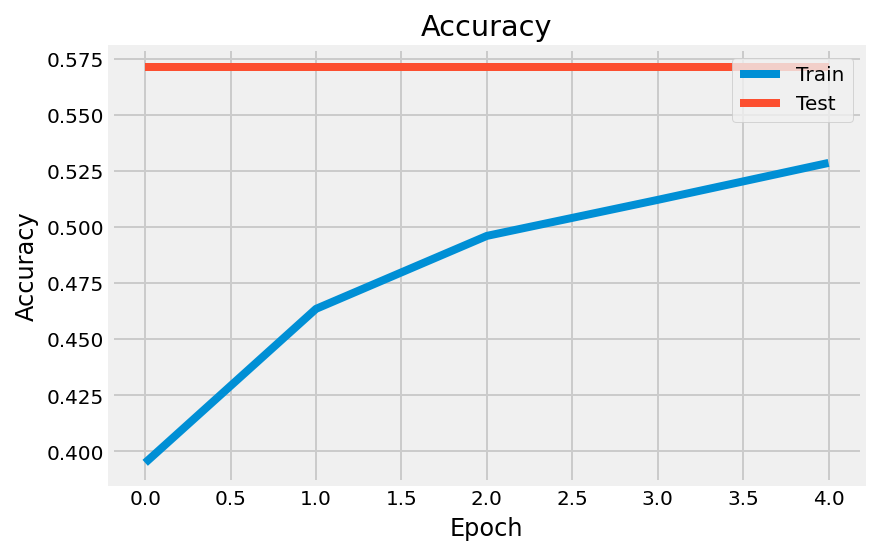

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.style
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Pretrained Word2Vec

In [ ]:
#credit from:https://github.com/mjain72/Sentiment-Analysis-using-Word2Vec-and-LSTM/blob/master/SentimentAnalysisTwitter.py
w2vModel = word2vec.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True, limit=50000)
#Convert words to integers
tokenizer = Tokenizer()
label_encoder = preprocessing.LabelEncoder()
# unchanged dataset
# tokenizer.fit_on_texts(data['text_corrected'])
X = tokenizer.texts_to_sequences(data['text_corrected'])
Y = label_encoder.fit_transform(data['overall_sentiment'])
Y = to_categorical(Y)

# random oversampling dataset
# tokenizer.fit_on_texts(ros_df['text_corrected'])
# X = tokenizer.texts_to_sequences(ros_df['text_corrected'])
# Y = label_encoder.fit_transform(ros_df['overall_sentiment'])
# Y = to_categorical(Y)

# random undersampling dataset
# tokenizer.fit_on_texts(rus_df['text_corrected'])
# X = tokenizer.texts_to_sequences(rus_df['text_corrected'])
# Y = label_encoder.fit_transform(rus_df['overall_sentiment'])
# Y = to_categorical(Y)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
#length of memes caption to consider
maxlen = 100
#add padding
X = pad_sequences(X, maxlen=maxlen)
print(X.shape)

(5825, 100)


In [ ]:
embedding_layer = Embedding(input_dim=w2vModel.syn0.shape[0], output_dim=w2vModel.syn0.shape[1], weights=[w2vModel.syn0], 
                            input_length=X.shape[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [ ]:
def get_rnn_model():
    model = Sequential()
    
    model.add(embedding_layer)
    model.add(LSTM(256))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    
    model.summary()
    
    return model

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.1, random_state = SEED)

In [ ]:
modelRNN = get_rnn_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)              

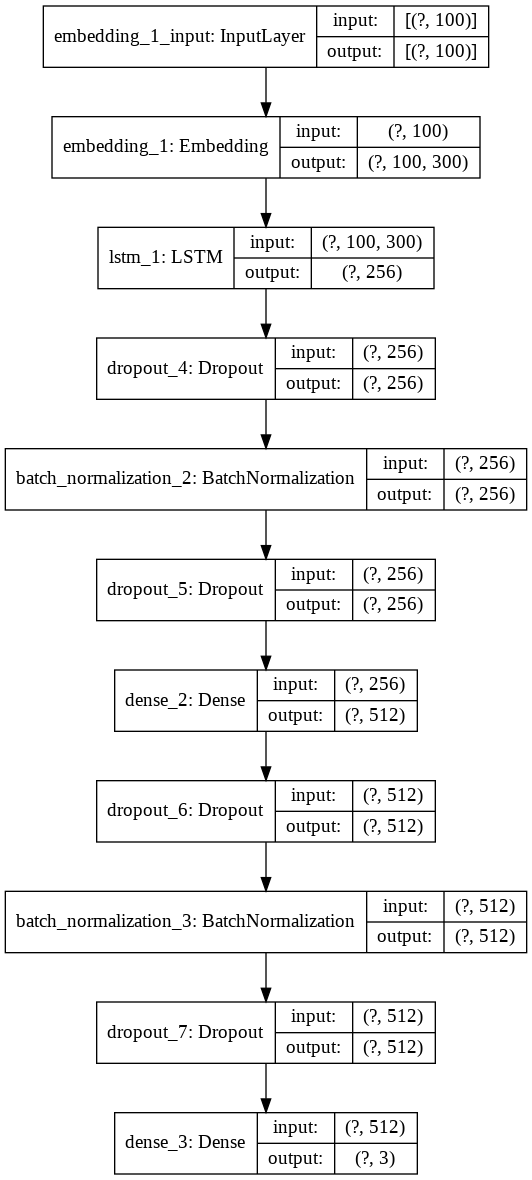

In [ ]:
plot_model(modelRNN, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
modelRNN.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
%%time
batch_size = 64
history = modelRNN.fit(X_train, 
                    Y_train, 
                    epochs = 5, 
                    batch_size=batch_size, 
                    validation_split=0.1
                    )

Epoch 1/5
60/60 [==============================] - 14s 233ms/step - loss: 0.6500 - accuracy: 0.7482 - val_loss: 0.9247 - val_accuracy: 0.5892
Epoch 2/5
60/60 [==============================] - 13s 217ms/step - loss: 0.2127 - accuracy: 0.9222 - val_loss: 0.9552 - val_accuracy: 0.5329
Epoch 3/5
60/60 [==============================] - 13s 214ms/step - loss: 0.1668 - accuracy: 0.9454 - val_loss: 1.0172 - val_accuracy: 0.5516
Epoch 4/5
60/60 [==============================] - 12s 206ms/step - loss: 0.1265 - accuracy: 0.9533 - val_loss: 1.1771 - val_accuracy: 0.5587
Epoch 5/5
60/60 [==============================] - 12s 204ms/step - loss: 0.0915 - accuracy: 0.9707 - val_loss: 1.5109 - val_accuracy: 0.5329
CPU times: user 1min 34s, sys: 2.33 s, total: 1min 37s
Wall time: 1min 8s


In [ ]:
y_pre = modelRNN.predict(X_test)
y_pre, Y_test

(array([[9.9567557e-03, 9.5035611e-03, 9.8053968e-01],
        [4.2837881e-02, 6.0127791e-02, 8.9703429e-01],
        [5.9849222e-04, 8.8183697e-05, 9.9931335e-01],
        ...,
        [9.3075849e-02, 1.0704755e-01, 7.9987657e-01],
        [5.3781442e-02, 6.3013804e-01, 3.1608051e-01],
        [1.0009384e-01, 1.4279754e-01, 7.5710869e-01]], dtype=float32),
 array([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], dtype=float32))

In [ ]:
from sklearn.metrics import classification_report
Y_pre = np.zeros_like(y_pre)
Y_pre[np.arange(len(y_pre)), y_pre.argmax(1)] = 1

print(classification_report(Y_test, Y_pre, target_names=["negative","neutral","positive"]))

              precision    recall  f1-score   support

    negative       0.50      0.10      0.17        49
     neutral       0.54      0.37      0.44       184
    positive       0.58      0.82      0.68       240

   micro avg       0.57      0.57      0.57       473
   macro avg       0.54      0.43      0.43       473
weighted avg       0.56      0.57      0.53       473
 samples avg       0.57      0.57      0.57       473

